# Parte de Data Science
Autores:
Júlio Limoli,
Marcos Ferreira,
Victor Araki

In [2]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, r2_score, accuracy_score, recall_score,
                            roc_auc_score, confusion_matrix, classification_report, precision_score, roc_curve)
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

sns.set()
pio.templates.default = 'plotly_dark'

## Importando DataFrame 

Já possui separação em treino e validação pelo notebook "split_DE.ipynb"

In [4]:
df = pd.read_csv('./bases/application_splitado_07.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Flag_Treino
0,456162,False,Cash loans,F,False,False,0,112500.0,700830.0,22738.5,...,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,True
1,134978,False,Cash loans,F,False,False,0,90000.0,375322.5,14422.5,...,False,False,False,0.0,0.0,0.0,1.0,0.0,3.0,True
2,318952,False,Cash loans,M,True,False,0,180000.0,544491.0,16047.0,...,False,False,False,0.0,0.0,0.0,1.0,1.0,3.0,False
3,361264,False,Cash loans,F,False,True,0,270000.0,814041.0,28971.0,...,False,False,False,0.0,0.0,0.0,0.0,1.0,4.0,True
4,260639,False,Cash loans,F,False,True,0,144000.0,675000.0,21906.0,...,False,False,False,0.0,0.0,0.0,10.0,0.0,0.0,True


In [10]:
df_train = df[df['Flag_Treino'] == True]
df_test = df[df['Flag_Treino'] == False]

print(df_train.shape)
print(df_test.shape)

(172206, 90)
(73802, 90)


# Conversão de Variáveis Categóricas

In [37]:
df_train_dummies = pd.get_dummies(df_train)
df_train_dummies.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,456162,False,False,False,0,112500.0,700830.0,22738.5,585000.0,0.019689,...,0,0,0,0,0,0,0,0,0,0
1,134978,False,False,False,0,90000.0,375322.5,14422.5,324000.0,0.025164,...,0,0,0,0,0,0,0,0,0,0
3,361264,False,False,True,0,270000.0,814041.0,28971.0,679500.0,0.046220,...,0,0,0,0,0,0,0,0,0,1
4,260639,False,False,True,0,144000.0,675000.0,21906.0,675000.0,0.026392,...,0,0,0,0,0,0,0,1,0,0
6,378296,True,False,True,0,72000.0,197820.0,15534.0,180000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0


## Selecao de Features

Foi utilizado o RFC para selecionar as features mais importantes, fez-se testes com 20, 15, 10 features e também utilizando a logistic regression e XGB classifier. Esses testes estão descritos no notebook "parte_DS.ipynb" e o melhor resultado foram as 20 features, mas subtraimos o "OWN_CAR_AGE", visto que 65% do dataset dessa feature era nulo

In [38]:
features_rfc_19 = ['TARGET','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 
 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'LIVINGAREA_MEDI', 
 'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M', 
 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working', 
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'ORGANIZATION_TYPE_XNA']

Visto que há muitas features no dataset, a análise exploratória será focada nessas 20 features

In [39]:
df_train_dummies = df_train_dummies[features_rfc_19]

## Analise Exploratória

In [41]:
df_train_dummies.shape

(172206, 20)

In [42]:
df_train_dummies.describe()

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,LIVINGAREA_MEDI,DAYS_LAST_PHONE_CHANGE,CODE_GENDER_M,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,ORGANIZATION_TYPE_XNA
count,1.722060e+05,172199.000000,1.720450e+05,172206.000000,172206.000000,172206.000000,172206.000000,75030.000000,1.718340e+05,137929.000000,85696.000000,172206.000000,172206.000000,172206.000000,172206.000000,172206.000000,172206.000000,172206.000000
mean,5.991165e+05,27117.311108,5.384268e+05,-16049.126761,64217.813235,-2992.398871,2.031758,0.502089,5.137885e-01,0.511090,0.108479,-961.214656,0.341597,0.181126,0.515812,0.242669,0.711160,0.181167
std,4.030929e+05,14535.393960,3.700106e+05,4367.606871,141610.005063,1509.469362,0.503057,0.211132,1.910387e-01,0.194387,0.111831,827.439111,0.474246,0.385124,0.499751,0.428698,0.453225,0.385157
min,4.500000e+04,1615.500000,4.050000e+04,-25229.000000,-17912.000000,-6383.000000,1.000000,0.014568,8.173617e-08,0.000527,0.000000,-4173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.700000e+05,16524.000000,2.385000e+05,-19700.000000,-2752.000000,-4297.000000,2.000000,0.334246,3.915206e-01,0.370650,0.045700,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.130000e+05,24907.500000,4.500000e+05,-15770.000000,-1214.000000,-3248.000000,2.000000,0.505565,5.647658e-01,0.537070,0.075000,-755.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,8.086500e+05,34596.000000,6.795000e+05,-12424.000000,-289.000000,-1719.000000,2.000000,0.675129,6.634365e-01,0.667458,0.130400,-271.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,4.050000e+06,258025.500000,4.050000e+06,-7676.000000,365243.000000,0.000000,3.000000,0.951624,8.549997e-01,0.896010,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Heatmap

<AxesSubplot:>

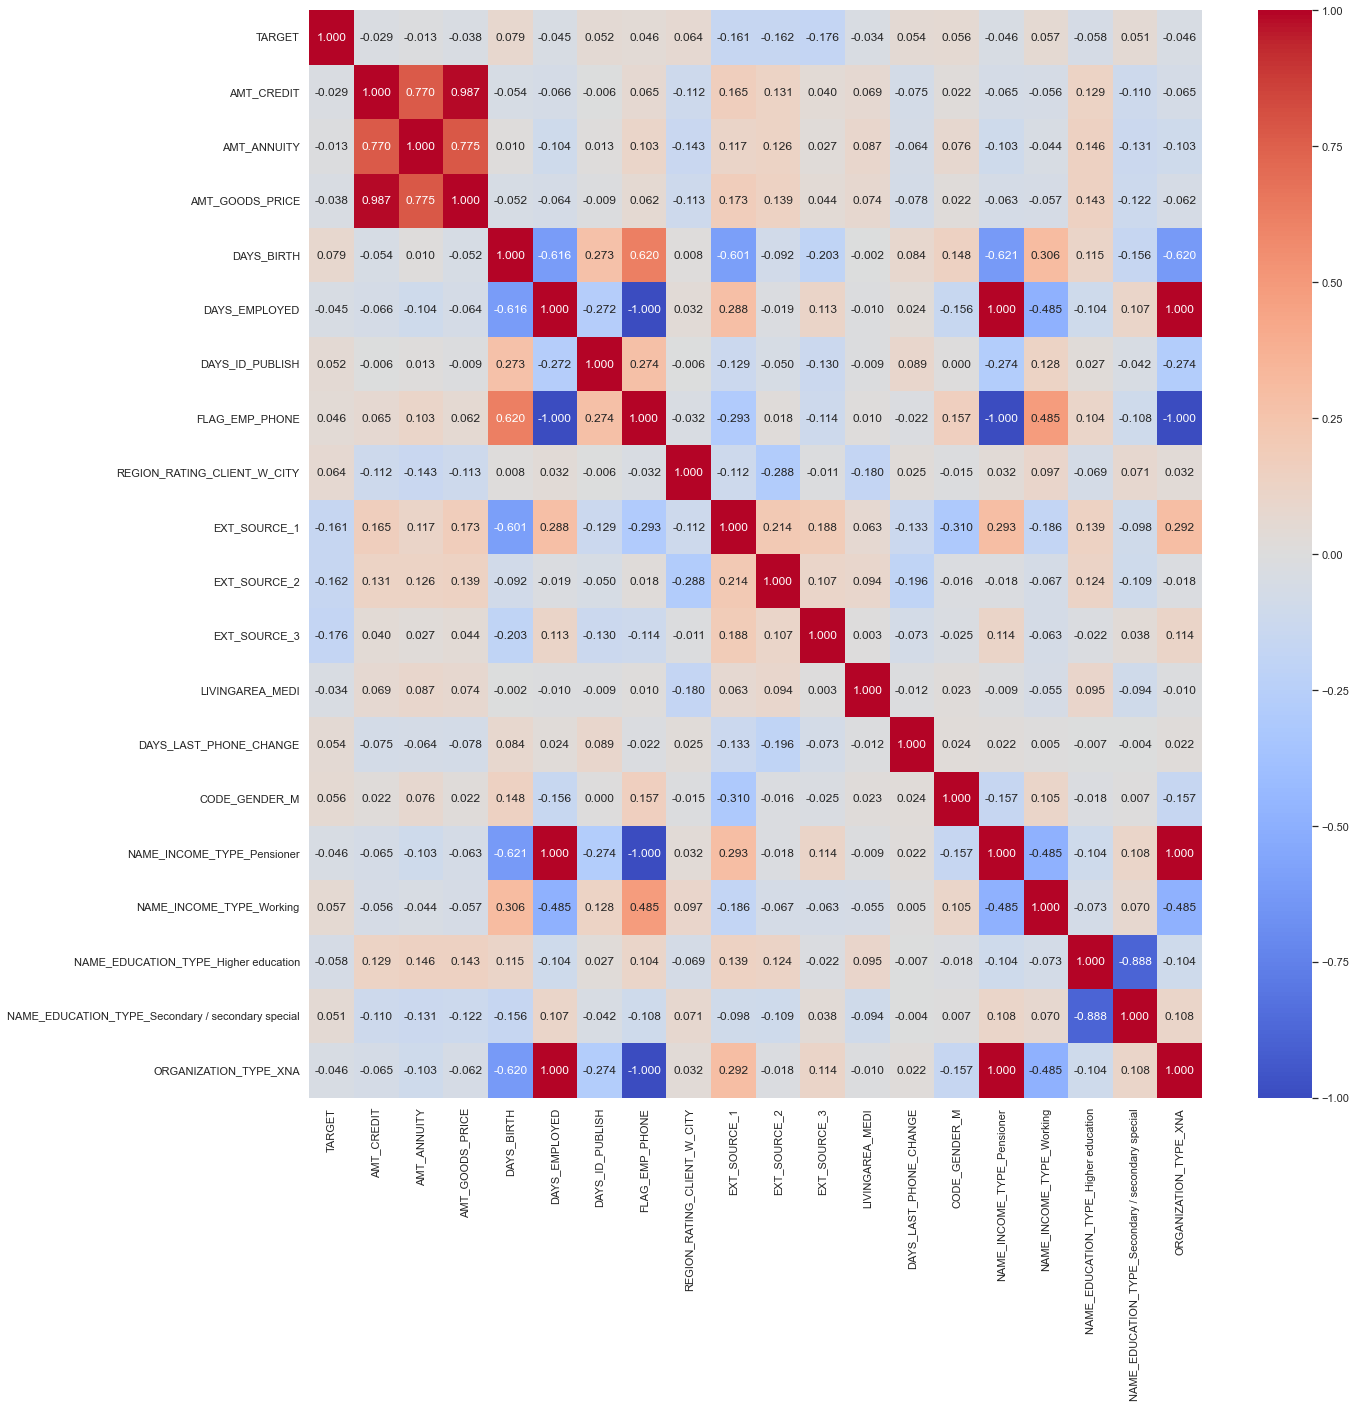

In [43]:
plt.figure(figsize=(20,20))

sns.heatmap(
    data=df_train_dummies.corr(), 
    cmap='coolwarm', 
    annot=True, 
    vmax=1, 
    vmin=-1,
    fmt='.3f'
    )

Após analisar o heatmap, decidimos excluir 3 features que possuem forte correlação com outras. </br>
NAME_INCOME_TYPE_Pensioner </br>
ORGANIZATION_TYPE_XNA </br>
AMT_CREDIT </br>

In [45]:
df_train_dummies.drop(['NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA', 'AMT_CREDIT'], axis=1, inplace=True)

<AxesSubplot:>

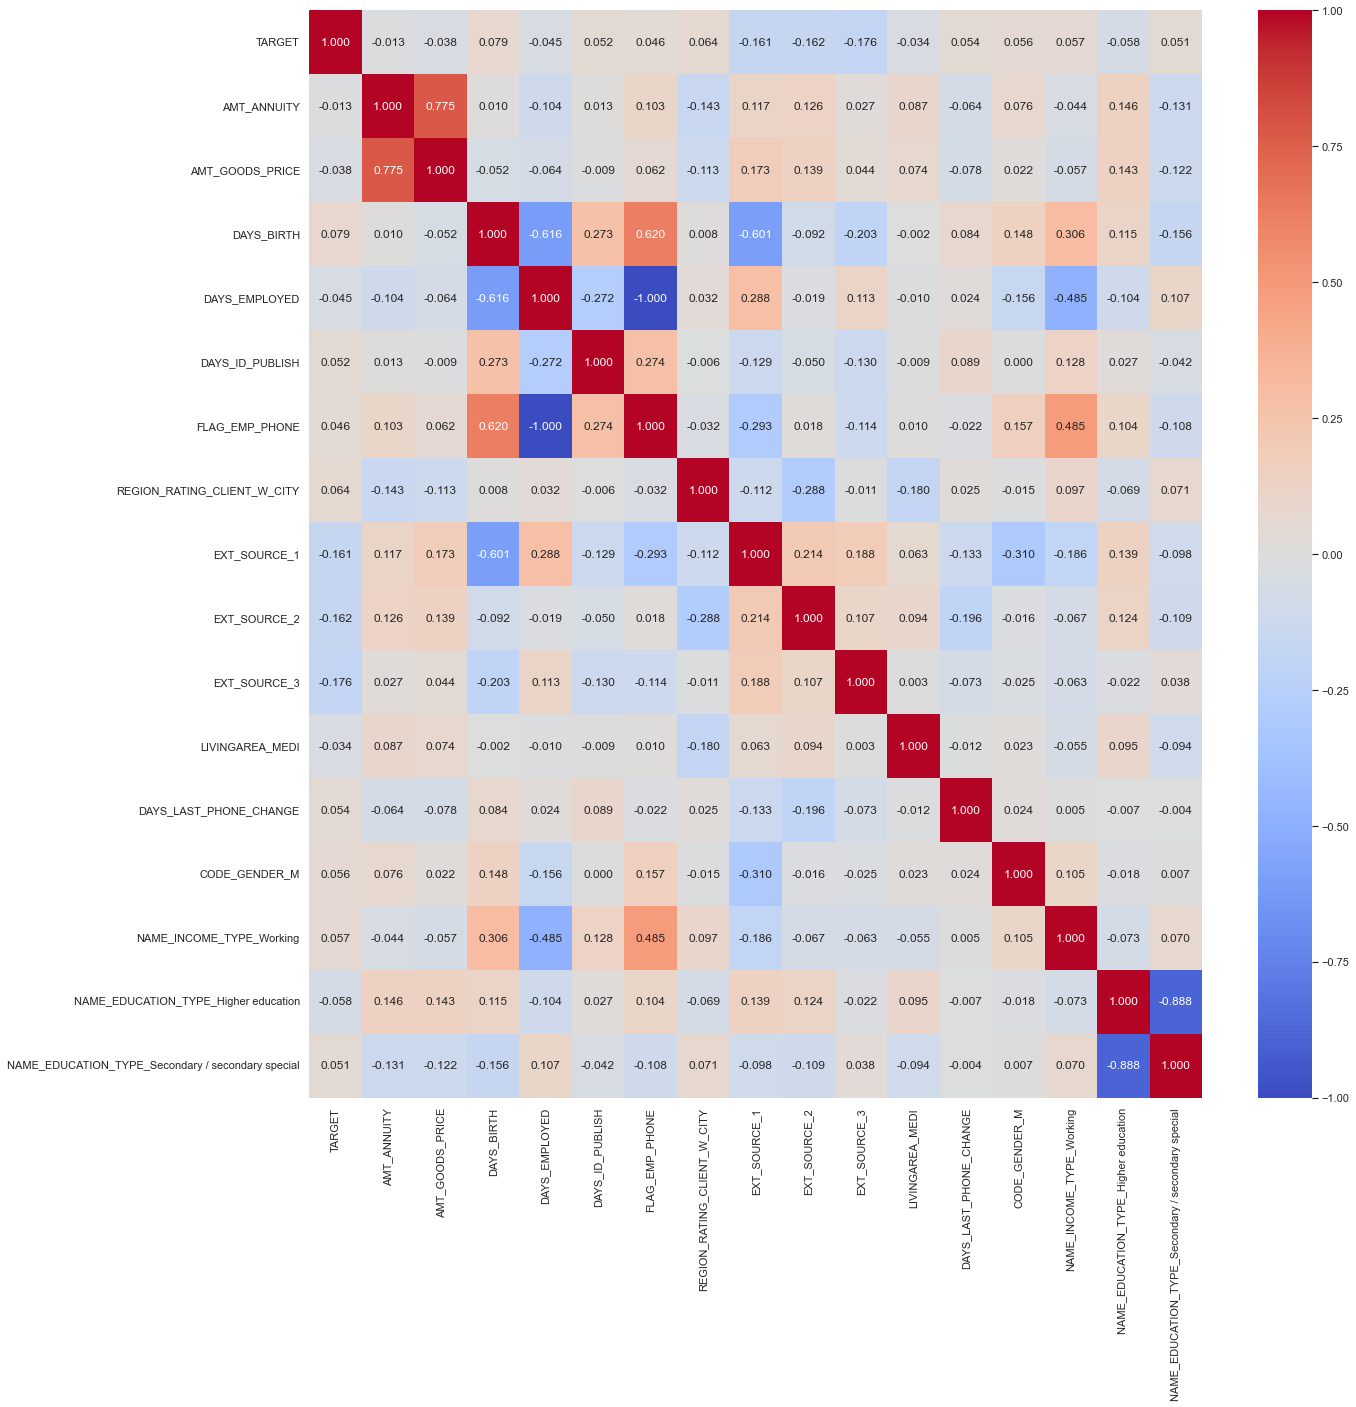

In [46]:
plt.figure(figsize=(20,20))

sns.heatmap(
    data=df_train_dummies.corr(), 
    cmap='coolwarm', 
    annot=True, 
    vmax=1, 
    vmin=-1,
    fmt='.3f'
    )


# Preenchendo os Valores Omissos – Imputação (Data Cleaning)

In [4]:
#Criando um Dataframe com as colunas e sua respectiva quantidade de valores nulos
cols_w_null_values = pd.DataFrame(df.isnull().sum(), columns = ['Null'])
cols_w_null_values = cols_w_null_values[cols_w_null_values['Null'] != 0]
cols_w_null_values


,Null
AMT_ANNUITY,10
AMT_GOODS_PRICE,226
NAME_TYPE_SUITE,1048
OWN_CAR_AGE,162359
OCCUPATION_TYPE,77237
CNT_FAM_MEMBERS,1
EXT_SOURCE_1,138803
EXT_SOURCE_2,544
EXT_SOURCE_3,48728
APARTMENTS_MEDI,124955


In [5]:
#Removendo linhas com entradas nulas em colunas que apresentam menos do que 1000 observações nulas ()
col_index = cols_w_null_values[cols_w_null_values['Null'] < 1000].index

for col in col_index:
    df = df.dropna(subset=list(col_index), axis=0)

In [6]:
#Passando por cada coluna que apresenta valores nulos e fazendo a inserção de dados
for col in cols_w_null_values.index:
    if (col[0:14] == 'AMT_REQ_CREDIT'):
        df[col].fillna(0, inplace=True)  
    elif (df[col].dtypes == int) or (df[col].dtypes == float): #Inserindo a mediana para colunas numéricas
        df[col].fillna(df[col].median(), inplace=True)  
    else: #Inserindo a moda para os demais tipos de coluna
        df[col].fillna(df[col].mode()[0], inplace=True)

# Balanceamento de Amostras

In [8]:
#É possível ver que existe um desbalanceamento na variável de estudo.
df_dummies['TARGET'].value_counts()

False    226038
True      19970
Name: TARGET, dtype: int64

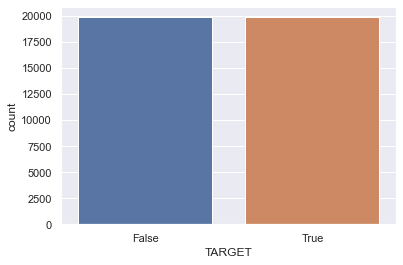

In [8]:
#Para contornar esse problema utilizaremos o NearMiss para fazer o balanceamento de amostras.
X = df_dummies.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df_dummies['TARGET']

X_under, y_under = RandomUnderSampler(random_state=42).fit_resample(X, y)

sns.countplot(x=y_under)

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

# Seleção de Features

In [13]:
# model = LogisticRegression(max_iter=10000, random_state = 42)
# rfe = RFE(model, n_features_to_select = 20)
# fit = rfe.fit(X_train, y_train)

# print(f"Número de Features: {rfe.n_features_to_select}")
# print(f"Features Selecionadas: {rfe.get_feature_names_out()}")

Número de Features: 20
Features Selecionadas: ['AMT_CREDIT' 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'CNT_FAM_MEMBERS'
 'REGION_RATING_CLIENT' 'REGION_RATING_CLIENT_W_CITY'
 'HOUR_APPR_PROCESS_START' 'EXT_SOURCE_2' 'OBS_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'DAYS_LAST_PHONE_CHANGE'
 'AMT_REQ_CREDIT_BUREAU_YEAR' 'CODE_GENDER_M' 'NAME_INCOME_TYPE_Working'
 'NAME_EDUCATION_TYPE_Secondary / secondary special']


# Criação de Modelos

In [9]:
#Modelo SEM 'OWN_CAR_AGE'
X_train_1 = X_train[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']]


cross_validate(estimator = LogisticRegression(max_iter=10000), X = X_train_1, y = y_train, scoring = ['precision','recall','roc_auc'], return_train_score = True)


{'fit_time': array([0.81604671, 0.74604273, 0.52002954, 0.58603334, 0.6550374 ]),
 'score_time': array([0.05200291, 0.01800108, 0.01800132, 0.02100134, 0.03400183]),
 'test_precision': array([0.58107029, 0.58949881, 0.57333843, 0.5777439 , 0.58756395]),
 'train_precision': array([0.58475496, 0.58219977, 0.58420746, 0.58296651, 0.58115699]),
 'test_recall': array([0.52338129, 0.53309353, 0.53992806, 0.54532374, 0.53705036]),
 'train_recall': array([0.53327338, 0.53884892, 0.54091727, 0.54784173, 0.53030576]),
 'test_roc_auc': array([0.60533681, 0.61015884, 0.60082272, 0.59719177, 0.60871446]),
 'train_roc_auc': array([0.60610059, 0.60467712, 0.60659435, 0.60746189, 0.60490235])}

In [43]:
#Modelo com 'OWN_CAR_AGE'
X_train_2 = X_train[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'OWN_CAR_AGE', 'FLAG_OWN_CAR',
 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']]


cross_validate(estimator = LogisticRegression(max_iter=10000), X = X_train_2, y = y_train, scoring = ['precision','recall','roc_auc'], return_train_score = True)


{'fit_time': array([1.41608095, 0.70404029, 1.20906949, 1.09606266, 0.94305396]),
 'score_time': array([0.06200337, 0.04400253, 0.12100673, 0.04000211, 0.03800201]),
 'test_precision': array([0.58107029, 0.58900836, 0.57350134, 0.57796416, 0.58749508]),
 'train_precision': array([0.5846973 , 0.58228833, 0.58417574, 0.58307   , 0.58108374]),
 'test_recall': array([0.52338129, 0.53201439, 0.54028777, 0.54532374, 0.53741007]),
 'train_recall': array([0.53327338, 0.53866906, 0.54046763, 0.54757194, 0.53039568]),
 'test_roc_auc': array([0.60534533, 0.61017368, 0.60082181, 0.59722637, 0.60871589]),
 'train_roc_auc': array([0.60610195, 0.60468556, 0.60659833, 0.60747003, 0.6048954 ])}

In [44]:
#Modelo com 'OWN_CAR_AGE'
X_train_3 = X_train[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]


cross_validate(estimator = LogisticRegression(max_iter=10000), X = X_train_3, y = y_train, scoring = ['precision','recall','roc_auc'], return_train_score = True)


{'fit_time': array([0.15000844, 0.08000445, 0.09600568, 0.09800553, 0.07600451]),
 'score_time': array([0.02000141, 0.01400065, 0.01800084, 0.01800084, 0.01500106]),
 'test_precision': array([0.54324928, 0.54598071, 0.55093351, 0.55043712, 0.54208543]),
 'train_precision': array([0.54433866, 0.54546182, 0.54850498, 0.54917965, 0.5435642 ]),
 'test_recall': array([0.61223022, 0.61079137, 0.60503597, 0.58884892, 0.62086331]),
 'train_recall': array([0.6221223 , 0.61339928, 0.59388489, 0.59298561, 0.6182554 ]),
 'test_roc_auc': array([0.57563453, 0.58023055, 0.5838185 , 0.57875387, 0.5810617 ]),
 'train_roc_auc': array([0.58167868, 0.58001993, 0.57888458, 0.57985368, 0.58081273])}

In [45]:
cross_validate(estimator = LogisticRegression(max_iter=10000), X = X_train, y = y_train, scoring = ['precision','recall','roc_auc'], return_train_score = True)


{'fit_time': array([4.66926694, 6.85339189, 4.11423516, 6.65838075, 4.74027109]),
 'score_time': array([0.25601459, 0.23501372, 0.26101494, 0.31901813, 0.2520144 ]),
 'test_precision': array([0.58027157, 0.58767396, 0.57317539, 0.57808324, 0.58816568]),
 'train_precision': array([0.58476247, 0.58288822, 0.58432858, 0.58256881, 0.58126233]),
 'test_recall': array([0.52266187, 0.53165468, 0.53956835, 0.54460432, 0.53633094]),
 'train_recall': array([0.53354317, 0.5397482 , 0.54118705, 0.54820144, 0.53003597]),
 'test_roc_auc': array([0.60544565, 0.61008744, 0.60067049, 0.59704212, 0.60829986]),
 'train_roc_auc': array([0.60609815, 0.60469932, 0.60665507, 0.60751715, 0.60490309])}

In [16]:
#cross_validate(estimator = RandomForestClassifier(random_state = 42, max_depth = 4), X = X_train_1, y = y_train, scoring = ['precision','recall','roc_auc'], return_train_score = True)
rand_fores = RandomForestClassifier(random_state = 42, max_depth = 4)
rand_fores.fit(X = X_train_1, y= y_train)

X_test_1 = X_test[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']]

y_proba = rand_fores.predict_proba(X = X_test_1)
roc_auc_score(y_score = y_proba[:,1], y_true = y_test)



0.6823473906480988

In [19]:
XGB = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
XGB.fit(X = X_train_1, y= y_train)

X_test_1 = X_test[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']]

y_proba = XGB.predict_proba(X = X_test_1)
roc_auc_score(y_score = y_proba[:,1], y_true = y_test)

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

0.6851445016553945

# Outros

In [8]:
#Checagem se existe alguma constante
[c for c in df.select_dtypes(include=['number']).columns if df[c].std() == 0]

[]

In [12]:
print(df['TARGET'].dtypes == bool)

True


In [10]:
#Checando colunas que tem muitos valores unicos
[c for c in df.select_dtypes(exclude=['number']).columns if df[c].nunique() > 10]

['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

#### Analisando os valores unicos do occupation_type e organizartion_type

In [25]:
df['OCCUPATION_TYPE'].unique()

array(['Core staff', 'High skill tech staff', 'Managers', nan, 'Laborers',
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Accountants', 'Low-skill Laborers', 'Security staff',
       'Realty agents', 'Private service staff', 'Medicine staff',
       'Secretaries', 'HR staff', 'Waiters/barmen staff', 'IT staff'],
      dtype=object)

In [23]:
df['ORGANIZATION_TYPE'].unique()

array(['Trade: type 2', 'Business Entity Type 3',
       'Business Entity Type 1', 'XNA', 'Transport: type 4',
       'Self-employed', 'Industry: type 9', 'Industry: type 3',
       'Trade: type 7', 'Police', 'School', 'Mobile', 'Housing',
       'Government', 'Construction', 'Bank', 'Other', 'Industry: type 11',
       'Trade: type 1', 'Medicine', 'Industry: type 7', 'Kindergarten',
       'Business Entity Type 2', 'Security Ministries', 'Electricity',
       'Industry: type 4', 'Trade: type 3', 'Agriculture', 'Military',
       'Trade: type 6', 'Hotel', 'Security', 'Legal Services',
       'Industry: type 1', 'Restaurant', 'Industry: type 12', 'Services',
       'Realtor', 'University', 'Industry: type 5', 'Transport: type 2',
       'Industry: type 2', 'Advertising', 'Transport: type 3',
       'Emergency', 'Culture', 'Postal', 'Telecom', 'Insurance',
       'Transport: type 1', 'Cleaning', 'Industry: type 10',
       'Trade: type 4', 'Industry: type 6', 'Religion',
       'Industry

### Analisando as colunas categóricas

In [20]:
df.select_dtypes(include='bool')

,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,False,False,False,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,True,True,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,False,False,True,True,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246004,False,False,True,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246005,True,False,False,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
246006,True,True,False,True,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Tentando fazer o primeiro modelo sem as 2 categoricas com muitas unique values

In [9]:
#df_sem_1 = df.drop(['ORGANIZATION_TYPE', 'OCCUPATION_TYPE'], axis=1)
df_dummies = pd.get_dummies(df)
df_dummies.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,456162,False,False,False,0,112500.0,700830.0,22738.5,585000.0,0.019689,...,0,0,0,0,0,0,0,0,0,0
1,134978,False,False,False,0,90000.0,375322.5,14422.5,324000.0,0.025164,...,0,0,0,0,0,0,0,0,0,0
2,318952,False,True,False,0,180000.0,544491.0,16047.0,454500.0,0.035792,...,0,0,0,0,0,0,0,0,0,0
3,361264,False,False,True,0,270000.0,814041.0,28971.0,679500.0,0.046220,...,0,0,0,0,0,0,0,0,0,1
4,260639,False,False,True,0,144000.0,675000.0,21906.0,675000.0,0.026392,...,0,0,0,0,0,0,0,1,0,0


In [10]:
X = df_dummies.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df_dummies['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
lr = LogisticRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [25]:
df['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Other_B',
       'Children', 'Other_A', nan, 'Group of people'], dtype=object)

In [41]:
for col in cols_w_null_values.index:
    if col[-5:] == '_MEDI':
        df[col].fillna(df[col].median(), inplace=True)


In [40]:
cols_w_null_values.index

Index(['AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [ ]:
# fill missing values with mean column values
dataset.fillna(dataset.mean(), inplace=True)